# Clustering

##### Identifying different types of passes

---

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

By now, you should be familiar with all of these libraries

---

In [2]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

In [3]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [m['match_id'] for m in matches]

    all_events = []
    for match_id in tqdm(match_ids):

        events = requests.get(url=match_url.format(match_id)).json()
        passes = [x for x in events if x['type']['name'] == "Pass"]
                
        for p in passes:
            attributes = {
                "x": p['location'][0],
                "y": p['location'][1],
                "end_x": p['pass']['end_location'][0],
                "end_y": p['pass']['end_location'][1],
                "outcome": 0 if 'outcome' in p['pass'].keys() else 1,
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

The `parse_data` function has been adjusted such that only passes are collected, and some new attributes, including:
- `x` - the x-coordinate of the origin of the pass
    - ranges from `0 to 120`
- `y` - the y-coordinate of the origin of the pass
    - ranges from `0 to 80`
- `end_x` - the x-coordinate of the end of the pass
    - ranges from `0 to 120`
- `end_y` - the y-coordinate of the end of the pass
    - ranges from `0 to 80`
- `outcome` - did the pass complete successfully

---

In [4]:
competition_id = 43
season_id = 3
df = parse_data(competition_id, season_id)

100%|██████████| 64/64 [00:13<00:00,  4.82it/s]


In [5]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=50)

This time, we import `LogisticRegression` from `sklearn.linear_model` and create an object of it.

---

In [6]:
features = df[['x', 'y', 'end_x', 'end_y']]
fit = model.fit(features)

We create a new DataFrame represents the model features (the attributes we think are important).

Notice, this time we don't have a `labels` variable. This is because we don't have a prior understanding of what those labels should be. This makes this an **unsupervised** modeling approach.

We fit the model using .fit(), just like the other `sklearn` models.

---

In [7]:
df['cluster'] = model.predict(features)
df.head(10)

,x,y,end_x,end_y,outcome,cluster
0,60.0,41.0,44.0,40.0,1,18
1,46.0,41.0,39.0,27.0,1,8
2,40.0,28.0,41.0,75.0,1,15
3,43.0,76.0,38.0,41.0,1,41
4,38.0,38.0,54.0,21.0,1,24
5,56.0,19.0,63.0,3.0,1,48
6,60.0,3.0,44.0,13.0,1,7
7,45.0,22.0,48.0,53.0,1,15
8,52.0,55.0,68.0,79.0,1,4
9,67.0,77.0,54.0,69.0,1,38


We create a new column on the `pandas` DataFrame that represents which cluster each pass was classified into.

Again, we're benefitting from broadcasting so we don't need to loop through the data structure.

---

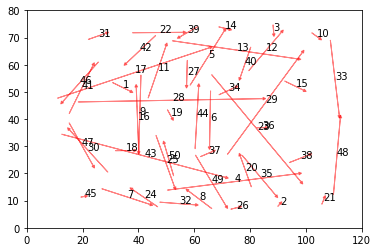

In [8]:
for i, (x, y, end_x, end_y) in enumerate(fit.cluster_centers_):
    plt.arrow(x, y, end_x-x, end_y-y,
              head_width=1,
              head_length=1,
              color='red',
              alpha=0.5,
              length_includes_head=True)
    
    plt.text((x+end_x)/2, (y+end_y)/2, str(i+1))
    
plt.xlim(0,120)
plt.ylim(0,80)
plt.show()

This loop plots (using `matplotlib`) each cluster `centroid` (or simply, `center` but that sounds less cool).

Notice the use of `enumeration` here. It's a nice python trick for iterating over a list while keeping an index.

This gives us a visually striking result, showing clear (but not perfect) symmetry. You can play with the `n_clusters` variable in the model declaration to adjust the model to the correct level of coarseness for your personal purposes.

Pass clusters are great to use as starting points for pass difficulty models. The typical components you would put into a pass difficulty model (e.g. `pass_distance`, `pass_angle`) can have very different effects on different pass types.

---

Devin Pleuler 2020